In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

In [8]:
df = pd.read_csv('D:\AML\data\processed\LI-Small_Trans.csv')

In [9]:
print(df.columns)
df.head()

Index(['Timestamp', 'From_Bank', 'From_Account', 'To_Bank', 'To_Account',
       'Amount_Received', 'Receiving_Currency', 'Amount_Paid',
       'Payment_Currency', 'Payment_Format', 'Is_Laundering',
       'Currency_Mismatch'],
      dtype='object')


,Timestamp,From_Bank,From_Account,To_Bank,To_Account,Amount_Received,Receiving_Currency,Amount_Paid,Payment_Currency,Payment_Format,Is_Laundering,Currency_Mismatch
0,2022-09-01 00:08:00,11,8000ECA90,11,8000ECA90,3195403.00,US Dollar,3195403.00,US Dollar,Reinvestment,0,False
1,2022-09-01 00:21:00,3402,80021DAD0,3402,80021DAD0,1858.96,US Dollar,1858.96,US Dollar,Reinvestment,0,False
2,2022-09-01 00:00:00,11,8000ECA90,1120,8006AA910,592571.00,US Dollar,592571.00,US Dollar,Cheque,0,False
3,2022-09-01 00:16:00,3814,8006AD080,3814,8006AD080,12.32,US Dollar,12.32,US Dollar,Reinvestment,0,False
4,2022-09-01 00:00:00,20,8006AD530,20,8006AD530,2941.56,US Dollar,2941.56,US Dollar,Reinvestment,0,False


In [10]:
G = nx.DiGraph()

In [14]:
for idx, row in df.iterrows():
    G.add_edge(row['From_Account'], row['To_Account'], amount=row['Amount_Paid'], timestamp=row['Timestamp'])

print(f"Graph info: {nx.info(G)}")

AttributeError: module 'networkx' has no attribute 'info'

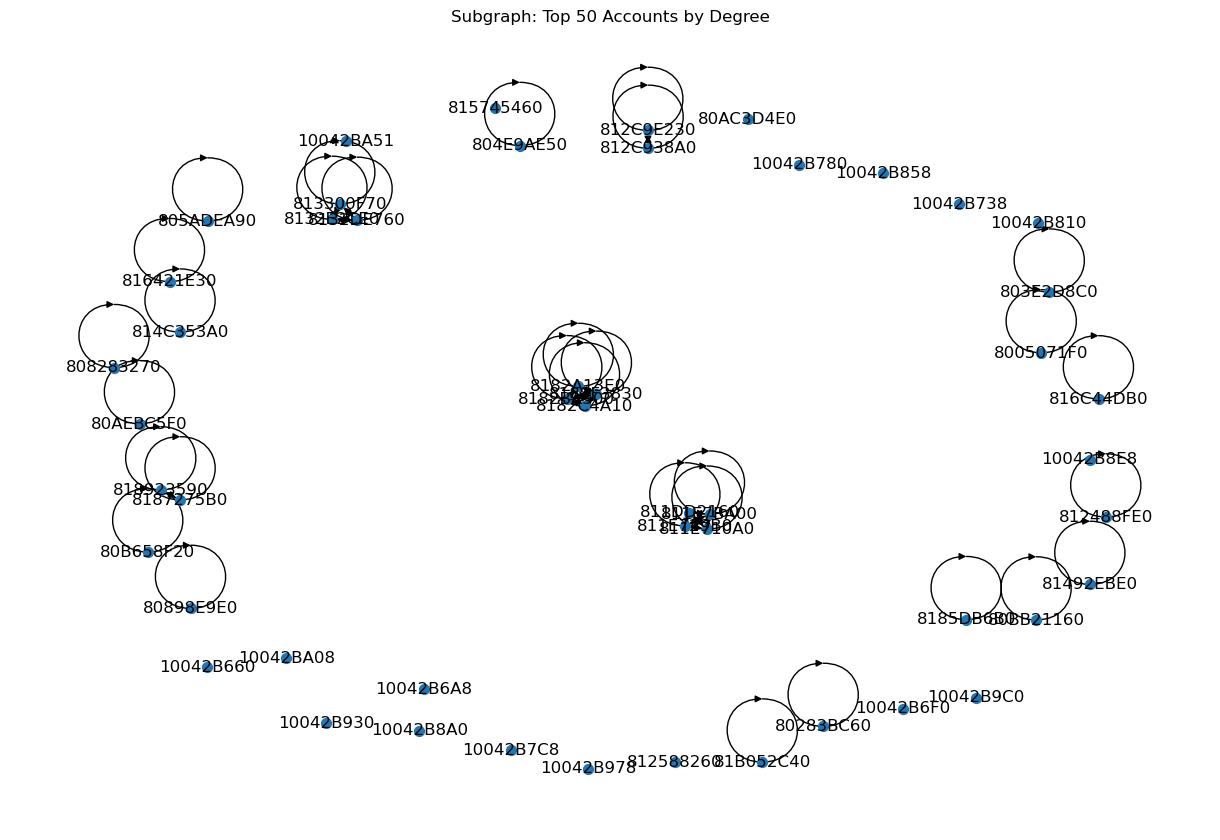

In [15]:
top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:50]
subgraph = G.subgraph([n for n, deg in top_nodes])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, k=0.15)
nx.draw(subgraph, pos, node_size=50, with_labels=True, arrowsize=10)
plt.title("Subgraph: Top 50 Accounts by Degree")
plt.show()

In [16]:
node_features = []
node_list = list(G.nodes)

for node in node_list:
    in_edges = G.in_edges(node, data=True)
    out_edges = G.out_edges(node, data=True)
    
    total_in_amount = sum([d['amount'] for _, _, d in in_edges])
    total_out_amount = sum([d['amount'] for _, _, d in out_edges])
    
    in_count = G.in_degree(node)
    out_count = G.out_degree(node)
    
    # Example: you can add more features like avg amount, time since last txn etc.
    node_features.append([total_in_amount, total_out_amount, in_count, out_count])

node_features = pd.DataFrame(node_features, index=node_list, columns=['total_in_amount', 'total_out_amount', 'in_count', 'out_count'])

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(node_features)

In [17]:
import numpy as np
np.random.seed(42)
labels = np.zeros(len(node_list))
suspicious_sample = np.random.choice(len(node_list), size=int(0.05*len(node_list)), replace=False)
labels[suspicious_sample] = 1

In [ ]:
# Create edge index tensor (2 x num_edges)
edges = list(G.edges())
edge_index = torch.tensor([[node_list.index(src) for src, _ in edges],
                           [node_list.index(dst) for _, dst in edges]], dtype=torch.long)

# Create feature tensor
x = torch.tensor(X, dtype=torch.float)

# Create label tensor
y = torch.tensor(labels, dtype=torch.long)

data = Data(x=x, edge_index=edge_index, y=y)

In [ ]:
train_mask, test_mask = train_test_split(range(len(node_list)), test_size=0.2, stratify=labels, random_state=42)
train_mask = torch.tensor(train_mask)
test_mask = torch.tensor(test_mask)


In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

model = GCN(in_channels=X.shape[1], hidden_channels=16, out_channels=2)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

data.train_mask = train_mask
data.test_mask = test_mask

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    train_acc = (pred[train_mask] == data.y[train_mask]).float().mean().item()
    test_acc = (pred[test_mask] == data.y[test_mask]).float().mean().item()
    return train_acc, test_acc, pred[test_mask], data.y[test_mask]

for epoch in range(1, 101):
    loss = train()
    if epoch % 10 == 0:
        train_acc, test_acc, _, _ = test()
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")


In [ ]:
model.eval()
out = model(data)
pred = out.argmax(dim=1)

print(classification_report(data.y[test_mask], pred[test_mask], target_names=["Clean", "Suspicious"]))

auc = roc_auc_score(data.y[test_mask].numpy(), torch.softmax(out[test_mask], dim=1)[:,1].detach().numpy())
print(f"ROC-AUC Score: {auc:.4f}")

In [ ]:
suspicious_nodes = [node_list[i] for i in test_mask if pred[i] == 1]

subgraph_suspicious = G.subgraph(suspicious_nodes)

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(subgraph_suspicious)
nx.draw(subgraph_suspicious, pos, node_size=100, node_color='red', with_labels=True)
plt.title("Suspicious Nodes Detected by GNN")
plt.show()
